In [ ]:
!git clone https://github.com/Yogesh7920/Neuro-Symbolic-AI.git 

Cloning into 'Neuro-Symbolic-AI'...
remote: Enumerating objects: 35, done.
remote: Counting objects: 100% (35/35), done.
remote: Compressing objects: 100% (29/29), done.
remote: Total 4226 (delta 9), reused 18 (delta 4), pack-reused 4191
Receiving objects: 100% (4226/4226), 808.15 MiB | 14.88 MiB/s, done.
Resolving deltas: 100% (34/34), done.
Checking out files: 100% (4131/4131), done.


In [ ]:
import IPython.display as display
import numpy as np
import pycocotools
import pycocotools.mask as maskutils
import json
from PIL import Image
import tensorflow as tf
import os
from sklearn.utils import shuffle
import time
import itertools

In [ ]:
data_dir = os.path.abspath('.') + '/Neuro-Symbolic-AI/CLEVR_mini' 

In [ ]:
no_images = 4000
split_ratio = 7
no_train = split_ratio*no_images//(split_ratio+1)

with open(data_dir+'/scenes/CLEVR_mini_coco_anns.json','r') as f:
    annot = json.load(f)

scenes = annot['scenes']

image_path = []

for im_no in range(no_images):
    
    image_path.append(data_dir + '/images/CLEVR_mini' + '_%06d.png' % (im_no))
    
image_path, scenes = shuffle(image_path, scenes, random_state = 5)

train_path = image_path[:no_train]
train_scene = scenes[:no_train]

val_path = image_path[no_train:]
val_scene = scenes[no_train:]


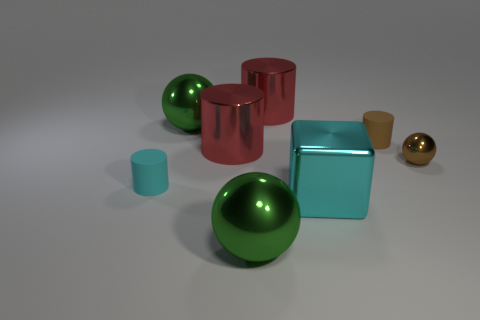

sphere cylinder cylinder sphere cylinder cube cylinder sphere 

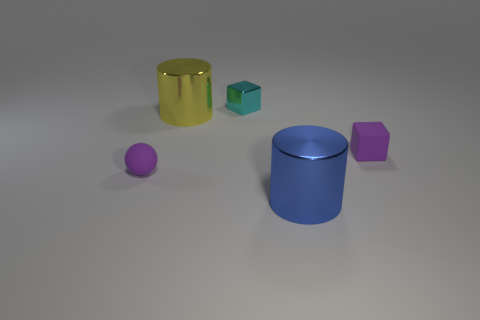

sphere cylinder cube cylinder cube 

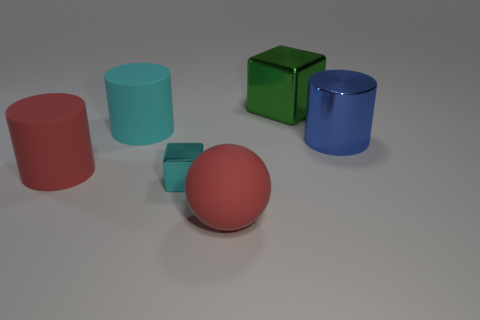

cube cylinder cube sphere cylinder cylinder 

In [ ]:
for i in range(3):
    display.display(Image.open(train_path[i]))
    for obj in train_scene[i]['objects']:
        print(obj['shape'], end=' ')

In [ ]:
masks = []
y_truth = []
train_path = []
val_path = []
train_mask = []
val_mask = []
for i,scene in enumerate(scenes):
    obj_cord = []
    
    for obj in scene['objects']:
        path_mask = []
        path_mask.append(image_path[i])
        path_mask.append(obj['mask']['counts'])
        obj_cord.append([np.dot(obj['3d_coords'], scene['directions']['right']).astype(np.float32),np.dot(obj['3d_coords'], scene['directions']['front']).astype(np.float32)])
        if i < no_train:
          train_path.append(image_path[i])
          train_mask.append(obj['mask']['counts'])
        else:
          val_path.append(image_path[i])
          val_mask.append(obj['mask']['counts'])
      
    # pad_cords = tf.stack(obj_cord, axis = 0)
    y_truth.append(obj_cord)


train_truth = list(itertools.chain(*y_truth[:no_train]))
val_truth = list(itertools.chain(*y_truth[no_train:]))

In [ ]:
max_objs = np.max([len(scene['objects']) for scene in scenes])
max_objs = 10
no_of_objects = 500
c = 3

In [ ]:
def load_audio_file(file_path):
    print("file_path: ",bytes.decode(file_path),type(bytes.decode(file_path)))
    return file_path

def mask(image_mask):
   return image_mask.numpy() 

def test_loss(model,val_path,val_mask,val_truth):
  eval = []
  coords = []
  for i in range(no_of_objects):
    data,_ = load_mask(val_path[i],val_mask[i],val_truth[i], train = False)
    eval.append(tf.expand_dims(data, axis = 0))
    coords.append((tf.expand_dims(val_truth[i], axis = 0)))
  
  data = tf.concat(eval,axis = 0)
  coords = tf.concat(coords,axis = 0)
  return (mse(coords,Attnet(eval)))

In [ ]:
def load_mask(image_path,image_mask,image_truth, train = True):

        if train:
          image_mask = image_mask.numpy()
        else:
          image_mask = image_mask

        image_mask = {
		                  'counts' : image_mask,
		                  'size' : [320,480]
                  	 }

    
        pad = tf.constant([[38, 37], [0, 0], [0, 0]])
        
        image = tf.io.read_file(image_path)
        image = tf.image.decode_png(image,channels= c, dtype = tf.uint16)
        Image = tf.image.resize(image,size = (149,224))

        obj_mask = tf.convert_to_tensor(maskutils.decode(image_mask), dtype = tf.uint16)
        obj_mask = tf.expand_dims(obj_mask,axis = -1)
        obj_mask = tf.cast( obj_mask*image, dtype = tf.float32) 
        obj_mask = tf.image.resize(obj_mask,size = (149,224))

        
        a = tf.pad(tf.keras.applications.resnet50.preprocess_input(Image),paddings = pad)
        b = tf.pad(tf.keras.applications.resnet50.preprocess_input(obj_mask),paddings = pad)
        
        data = tf.concat([b,a],axis = -1)

        return data,image_truth       


  

In [ ]:
batch_size = 100
dataset = tf.data.Dataset.from_tensor_slices((train_path,train_mask,train_truth))
dataset = dataset.map(lambda x,y,z: tf.py_function(load_mask, [x,y,z],[tf.float32,tf.float32]), num_parallel_calls=tf.data.experimental.AUTOTUNE)
dataset = dataset.shuffle(2000).batch(batch_size)
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [ ]:
k = tf.keras.applications.ResNet50(include_top = False,weights = None, 
                                      input_tensor = tf.keras.Input(shape = (224,224,2*c)) )
k.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 6) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 6)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 18880       conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [ ]:
class Att_net(tf.keras.Model):
    def __init__(self):
        super(Att_net,self).__init__()
        
#       image dimension change
        self.model = tf.keras.applications.ResNet50(include_top = False,weights = None, 
                                      input_tensor = tf.keras.Input(shape = (224,224,2*c)) )
        # self.Conv = tf.keras.layers.Conv2D(2, kernel_size=(7, 7), strides=(1, 1))
        self.flat = tf.keras.layers.Flatten()
        self.fc = tf.keras.layers.Dense(2)
    
    def call(self,x):
        
        x = self.model(x)
        # x = self.Conv(x)
        x = self.flat(x)
        x = self.fc(x)
        # x = tf.reshape(x,shape = (-1,2))

        return x

In [ ]:
Attnet = Att_net()
mse = tf.keras.losses.MeanSquaredError()

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.002, )
loss_plot = []
test_loss_plot = []

In [ ]:
@tf.function
def train_step(data,image_truth):
    
    with tf.GradientTape() as tape:
           
      image_pred = Attnet(data)
      image_loss = mse(image_truth, image_pred)
    
    variables = Attnet.trainable_variables

    k = optimizer.get_gradients(image_loss,variables)

    gradients = tape.gradient(image_loss, variables, unconnected_gradients = tf.UnconnectedGradients.NONE)

    optimizer.apply_gradients(zip(gradients, variables))
    
    return image_loss
                             

In [ ]:
tf.keras.callbacks.Callback()

In [ ]:
EPOCHS = 100

for epoch in range(0, EPOCHS):
    start = time.time()
    total_loss = 0
    val_loss = 0

    for (batch, (data,image_truth)) in enumerate(dataset):
         
        image_loss = train_step(data,image_truth)
        total_loss += image_loss


        if batch % 50 == 0:
            print ('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1, batch, image_loss.numpy()/batch_size))

    loss_plot.append(total_loss / len(train_path))
    val_loss = test_loss(Attnet, val_path, val_mask, val_truth)
    test_loss_plot.append(val_loss/no_of_objects)
    
    print ('Epoch {} Loss {:.6f} Val_Loss{:.6f}'.format(epoch + 1,total_loss/len(train_path),val_loss/no_of_objects))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))
 



Epoch 1 Batch 0 Loss 20451.0412
Epoch 1 Batch 50 Loss 143.2494
Epoch 1 Batch 100 Loss 15.5207
Epoch 1 Batch 150 Loss 19.4480
Epoch 1 Batch 200 Loss 9.6674
Epoch 1 Loss 1211804286976.000000 Val_Loss5.006227
Time taken for 1 epoch 716.9614617824554 sec

Epoch 2 Batch 0 Loss 8.6819
Epoch 2 Batch 50 Loss 6.0202
Epoch 2 Batch 100 Loss 5.2122
Epoch 2 Batch 150 Loss 4.0646
Epoch 2 Batch 200 Loss 4.2215
Epoch 2 Loss 5.181602 Val_Loss1.330004
Time taken for 1 epoch 695.6384994983673 sec

Epoch 3 Batch 0 Loss 2.4718
Epoch 3 Batch 50 Loss 3.1171
Epoch 3 Batch 100 Loss 2.6423
Epoch 3 Batch 150 Loss 1.5946
Epoch 3 Batch 200 Loss 1.6112
Epoch 3 Loss 2.686752 Val_Loss0.352720
Time taken for 1 epoch 693.8558790683746 sec

Epoch 4 Batch 0 Loss 1.4451
Epoch 4 Batch 50 Loss 3.4091
Epoch 4 Batch 100 Loss 1.7423
Epoch 4 Batch 150 Loss 1.0506
Epoch 4 Batch 200 Loss 1.0099
Epoch 4 Loss 1.654762 Val_Loss0.507649
Time taken for 1 epoch 693.2780694961548 sec

Epoch 5 Batch 0 Loss 2.0280
Epoch 5 Batch 50 Loss 16

In [ ]:
import matplotlib.pyplot as plt
plt.plot(np.arange(15),loss_plot)
Attnet.save('/contents/Neuro-Symbolic-AI') 

In [ ]:
k = [2,67,23,100,150]
for i in k:
  p,q = load_mask(val_path[i],val_mask[i],val_truth[i], train = False)
  e = Attnet(tf.expand_dims(p,axis = 0))
  print(e)
  print(val_truth[i])